# Interval Pattern Feature Engineering

## 목표
구간 변화 패턴을 활용한 강력한 feature 생성

## 주요 Feature
1. **구간 하락 패턴**: 연속 하락 개월 수, 하락 빈도, 하락 속도
2. **역사적 최악 지표**: 최저 구간 도달, 최고 구간 대비 격차
3. **회복 지표**: 회복 패턴, 변동성, 방향 전환 횟수
4. **교차 지표**: 매출 vs 고객 수 구간 divergence

## 핵심 인사이트
- 구간(interval)은 이미 상대적 순위를 나타내므로 절대값보다 **변화 패턴**이 중요
- **연속 하락**은 일시적 변동보다 폐업 위험의 강력한 신호
- 매출 구간과 고객 구간의 **divergence**는 문제의 원인 파악에 유용

## 1. 환경 설정

In [16]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.family'] = 'AppleGothic'

# 출력 설정
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

print("Libraries loaded successfully")

Libraries loaded successfully


In [17]:
# 커스텀 모듈 임포트
import sys
sys.path.append('..')

from pipeline.features import IntervalPatternFeatureEngine

print("Custom modules loaded successfully")

Custom modules loaded successfully


## 2. 데이터 로드

In [18]:
# 전처리된 데이터 로드
data_path = Path('../data/processed/preprocessed_data.csv')
df = pd.read_csv(data_path)

print(f"Loaded data shape: {df.shape}")
print(f"\nColumns: {len(df.columns)}")
print(f"Rows: {len(df):,}")
print(f"Unique merchants: {df['ENCODED_MCT'].nunique():,}")
print(f"Date range: {df['TA_YM'].min()} ~ {df['TA_YM'].max()}")

Loaded data shape: (86590, 47)

Columns: 47
Rows: 86,590
Unique merchants: 4,185
Date range: 202301 ~ 202412


In [19]:
# 구간 변수 확인
interval_cols = ['RC_M1_SAA', 'RC_M1_TO_UE_CT', 'RC_M1_UE_CUS_CN', 'RC_M1_AV_NP_AT']

print("Interval columns:")
for col in interval_cols:
    if col in df.columns:
        print(f"  {col}: {df[col].nunique()} unique values")
        print(f"    Range: {df[col].min()} ~ {df[col].max()}")
        print(f"    Distribution: {df[col].value_counts().sort_index().to_dict()}")
        print()

Interval columns:
  RC_M1_SAA: 6 unique values
    Range: 1 ~ 6
    Distribution: {1: 8799, 2: 13167, 3: 21800, 4: 21692, 5: 12912, 6: 8220}

  RC_M1_TO_UE_CT: 6 unique values
    Range: 1 ~ 6
    Distribution: {1: 8719, 2: 13023, 3: 21981, 4: 21945, 5: 14211, 6: 6711}

  RC_M1_UE_CUS_CN: 6 unique values
    Range: 1 ~ 6
    Distribution: {1: 8771, 2: 13147, 3: 21934, 4: 22026, 5: 14001, 6: 6711}

  RC_M1_AV_NP_AT: 6 unique values
    Range: 1 ~ 6
    Distribution: {1: 8690, 2: 13143, 3: 21918, 4: 21781, 5: 12888, 6: 8170}



## 3. Interval Pattern Features 생성

In [20]:
# IntervalPatternFeatureEngine 초기화
interval_engine = IntervalPatternFeatureEngine(
    merchant_col='ENCODED_MCT',
    date_col='TA_YM'
)

print("IntervalPatternFeatureEngine initialized")

IntervalPatternFeatureEngine initialized


In [21]:
# 모든 interval pattern features 생성
df_with_intervals = interval_engine.create_all_interval_features(
    df,
    interval_columns=interval_cols
)

print(f"\nOriginal shape: {df.shape}")
print(f"New shape: {df_with_intervals.shape}")
print(f"Features added: {df_with_intervals.shape[1] - df.shape[1]}")


CREATING ALL INTERVAL PATTERN FEATURES

Creating interval decline features...
Columns: 4
Windows: [3, 6, 12]
Created 44 interval decline features

Creating historical worst features...
Columns: 4
Created 20 historical worst features

Creating recovery indicators...
Columns: 4
Created 28 recovery indicator features

Creating cross-metric interval features...
Primary: RC_M1_SAA
Secondary: ['RC_M1_TO_UE_CT', 'RC_M1_UE_CUS_CN', 'RC_M1_AV_NP_AT']
Created 9 cross-metric interval features

INTERVAL PATTERN FEATURES COMPLETE
Total new features created: 101


Original shape: (86590, 47)
New shape: (86590, 148)
Features added: 101


## 4. Feature 검증 및 분석

In [22]:
# 새로 생성된 feature 목록
new_features = [col for col in df_with_intervals.columns if col not in df.columns]

print(f"\nTotal new features: {len(new_features)}")
print("\nFeature categories:")

categories = {
    'Decline patterns': [f for f in new_features if 'decline' in f or 'declining' in f],
    'Historical worst': [f for f in new_features if 'worst' in f or 'best' in f or 'distance' in f or 'since' in f],
    'Recovery indicators': [f for f in new_features if 'recovery' in f or 'recovering' in f or 'volatility' in f or 'direction' in f],
    'Cross-metric': [f for f in new_features if 'divergence' in f or 'aligned' in f],
    'Others': [f for f in new_features if not any(kw in f for kw in ['decline', 'declining', 'worst', 'best', 'distance', 'since', 'recovery', 'recovering', 'volatility', 'direction', 'divergence', 'aligned'])]
}

for cat, features in categories.items():
    if features:
        print(f"\n{cat}: {len(features)}")
        for f in features[:5]:  # Show first 5
            print(f"  - {f}")
        if len(features) > 5:
            print(f"  ... and {len(features) - 5} more")


Total new features: 101

Feature categories:

Decline patterns: 47
  - RC_M1_SAA_is_declining
  - RC_M1_SAA_consecutive_declines
  - RC_M1_SAA_decline_count_3m
  - RC_M1_SAA_decline_count_6m
  - RC_M1_SAA_decline_count_12m
  ... and 42 more

Historical worst: 20
  - RC_M1_SAA_worst_ever
  - RC_M1_SAA_best_ever
  - RC_M1_SAA_at_worst_now
  - RC_M1_SAA_distance_from_best
  - RC_M1_SAA_months_since_best
  ... and 15 more

Recovery indicators: 28
  - RC_M1_SAA_is_recovering
  - RC_M1_SAA_consecutive_recovery
  - RC_M1_SAA_recovery_after_decline
  - RC_M1_SAA_interval_volatility_3m
  - RC_M1_SAA_interval_volatility_6m
  ... and 23 more

Cross-metric: 9
  - divergence_RC_M1_SAA_vs_RC_M1_TO_UE_CT
  - aligned_decline_RC_M1_SAA_RC_M1_TO_UE_CT
  - divergence_magnitude_RC_M1_SAA_RC_M1_TO_UE_CT
  - divergence_RC_M1_SAA_vs_RC_M1_UE_CUS_CN
  - aligned_decline_RC_M1_SAA_RC_M1_UE_CUS_CN
  ... and 4 more

Others: 4
  - RC_M1_SAA_interval_change
  - RC_M1_TO_UE_CT_interval_change
  - RC_M1_UE_CUS_CN_in

In [23]:
# 샘플 가맹점의 interval pattern 확인
sample_merchant = df_with_intervals['ENCODED_MCT'].iloc[100]

sample_cols = [
    'ENCODED_MCT', 'TA_YM',
    'RC_M1_SAA',
    'RC_M1_SAA_interval_change',
    'RC_M1_SAA_is_declining',
    'RC_M1_SAA_consecutive_declines',
    'RC_M1_SAA_decline_count_3m',
    'RC_M1_SAA_worst_ever',
    'RC_M1_SAA_at_worst_now'
]

available_cols = [col for col in sample_cols if col in df_with_intervals.columns]

print(f"\nSample merchant: {sample_merchant}")
print("\nInterval pattern over time:")
display(df_with_intervals[df_with_intervals['ENCODED_MCT'] == sample_merchant][available_cols].head(15))


Sample merchant: 0041E4E5AE

Interval pattern over time:


,ENCODED_MCT,TA_YM,RC_M1_SAA,RC_M1_SAA_interval_change,RC_M1_SAA_is_declining,RC_M1_SAA_consecutive_declines,RC_M1_SAA_decline_count_3m,RC_M1_SAA_worst_ever,RC_M1_SAA_at_worst_now
22,0041E4E5AE,202301,2,NaN,0,0,0.0,2,1
16,0041E4E5AE,202302,2,0.0,0,0,0.0,2,1
8690,0041E4E5AE,202303,2,0.0,0,0,0.0,2,1
23,0041E4E5AE,202304,2,0.0,0,0,0.0,2,1
8689,0041E4E5AE,202305,2,0.0,0,0,0.0,2,1
11208,0041E4E5AE,202306,2,0.0,0,0,0.0,2,1
21322,0041E4E5AE,202307,2,0.0,0,0,0.0,2,1
21,0041E4E5AE,202308,2,0.0,0,0,0.0,2,1
19,0041E4E5AE,202309,2,0.0,0,0,0.0,2,1
62436,0041E4E5AE,202310,2,0.0,0,0,0.0,2,1


## 5. 타겟 변수와의 상관관계 분석


Top 20 interval pattern features correlated with 'will_close_3m':
RC_M1_SAA_at_worst_now                     0.012583
RC_M1_SAA_total_decline_12m                0.009734
RC_M1_AV_NP_AT_at_worst_now                0.009675
RC_M1_UE_CUS_CN_distance_from_best         0.009648
RC_M1_TO_UE_CT_months_since_best           0.008128
RC_M1_SAA_decline_count_12m                0.008007
RC_M1_SAA_decline_speed_6m                 0.007869
RC_M1_SAA_total_decline_6m                 0.007869
RC_M1_TO_UE_CT_decline_count_12m           0.007775
RC_M1_UE_CUS_CN_direction_changes_3m       0.007637
RC_M1_UE_CUS_CN_at_worst_now               0.007288
RC_M1_TO_UE_CT_best_ever                   0.007280
divergence_RC_M1_SAA_vs_RC_M1_UE_CUS_CN    0.006734
RC_M1_AV_NP_AT_total_decline_6m            0.006553
RC_M1_AV_NP_AT_decline_speed_6m            0.006553
RC_M1_AV_NP_AT_best_ever                   0.006501
RC_M1_SAA_months_since_best                0.006445
RC_M1_SAA_decline_count_3m                 0.0062

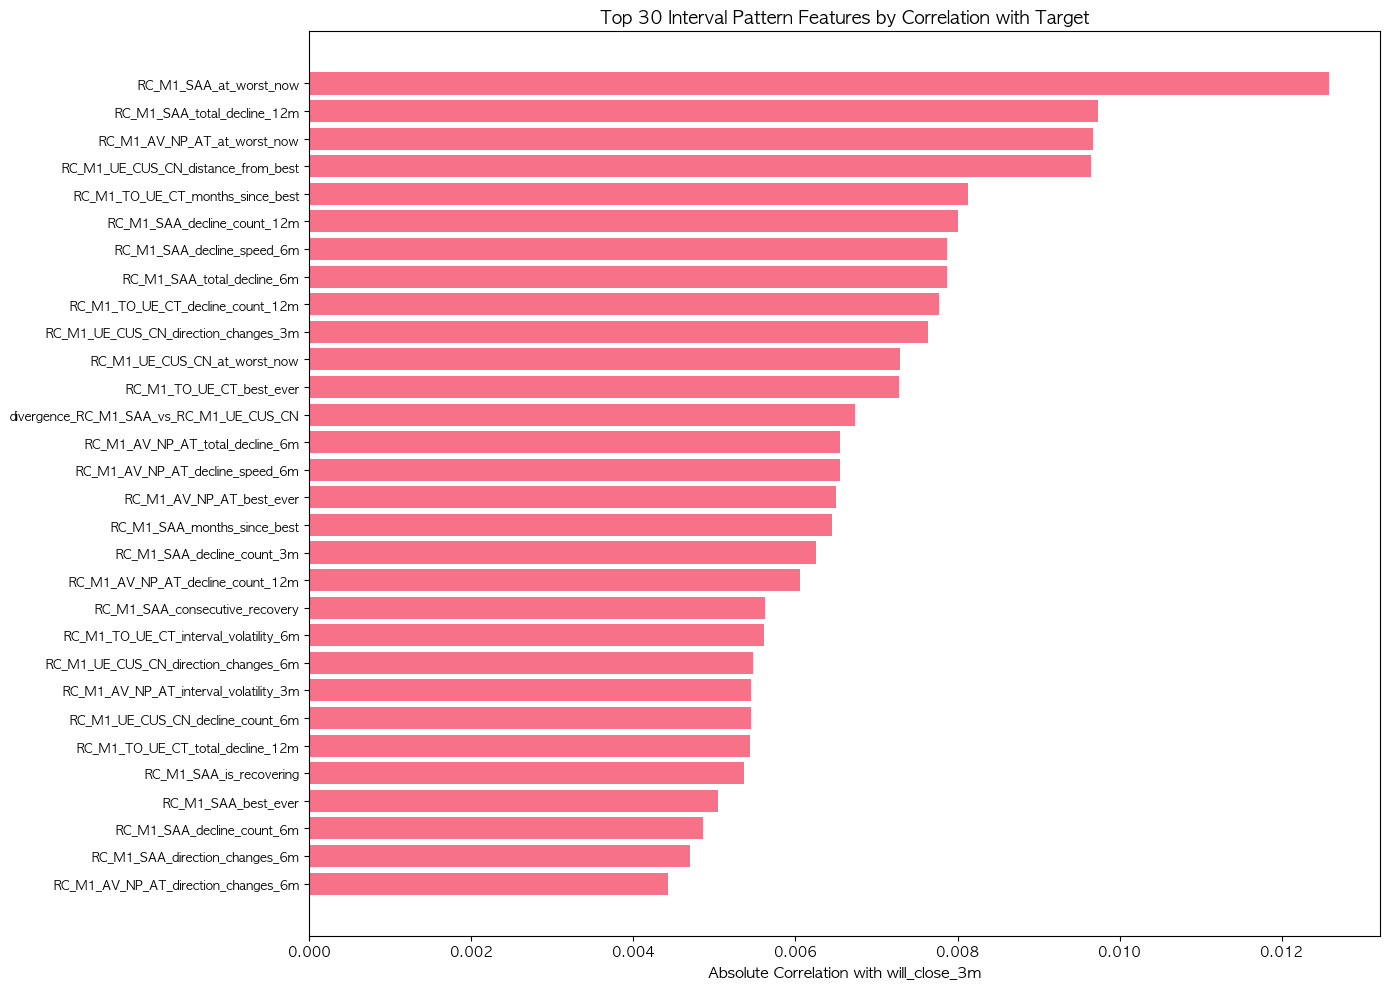

In [24]:
# 타겟 변수와의 상관관계 계산
if 'will_close_3m' in df_with_intervals.columns:
    correlations = df_with_intervals[new_features].corrwith(df_with_intervals['will_close_3m']).abs().sort_values(ascending=False)
    
    print("\nTop 20 interval pattern features correlated with 'will_close_3m':")
    print(correlations.head(20))
    
    # 시각화
    fig, ax = plt.subplots(figsize=(14, 10))
    top_corr = correlations.head(30)
    ax.barh(range(len(top_corr)), top_corr.values)
    ax.set_yticks(range(len(top_corr)))
    ax.set_yticklabels(top_corr.index, fontsize=9)
    ax.set_xlabel('Absolute Correlation with will_close_3m', fontsize=11)
    ax.set_title('Top 30 Interval Pattern Features by Correlation with Target', fontsize=13, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("\nTarget variable 'will_close_3m' not found")

## 6. 폐업/정상 가맹점 비교


Feature comparison: Will Close vs Normal


,Normal (0),Will Close (1),Difference
RC_M1_SAA_at_worst_now,0.573427,0.760417,0.186990
RC_M1_SAA_distance_from_best,0.536072,0.625000,0.088928
RC_M1_UE_CUS_CN_consecutive_declines,0.098261,0.125000,0.026739
aligned_decline_RC_M1_SAA_RC_M1_UE_CUS_CN,0.042477,0.062500,0.020023
RC_M1_SAA_consecutive_declines,0.137397,0.093750,-0.043647
RC_M1_SAA_decline_count_3m,0.373598,0.270833,-0.102765


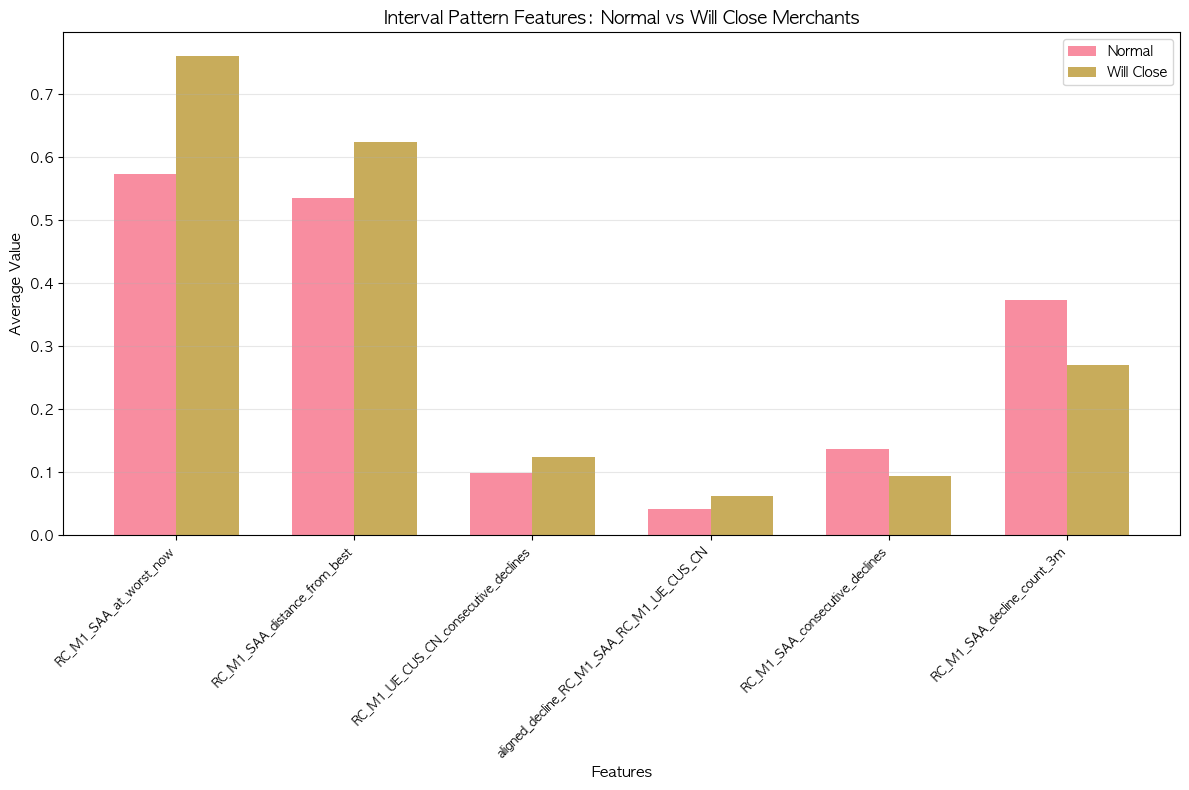

In [25]:
# 폐업 예정 vs 정상 가맹점 feature 평균 비교
if 'will_close_3m' in df_with_intervals.columns:
    # 주요 feature 선택
    key_features = [
        'RC_M1_SAA_consecutive_declines',
        'RC_M1_SAA_decline_count_3m',
        'RC_M1_SAA_at_worst_now',
        'RC_M1_SAA_distance_from_best',
        'aligned_decline_RC_M1_SAA_RC_M1_UE_CUS_CN',
        'RC_M1_UE_CUS_CN_consecutive_declines'
    ]
    
    available_features = [f for f in key_features if f in df_with_intervals.columns]
    
    comparison = df_with_intervals.groupby('will_close_3m')[available_features].mean()
    comparison = comparison.T
    comparison.columns = ['Normal (0)', 'Will Close (1)']
    comparison['Difference'] = comparison['Will Close (1)'] - comparison['Normal (0)']
    comparison = comparison.sort_values('Difference', ascending=False)
    
    print("\nFeature comparison: Will Close vs Normal")
    print("="*70)
    display(comparison)
    
    # 시각화
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(comparison))
    width = 0.35
    
    ax.bar(x - width/2, comparison['Normal (0)'], width, label='Normal', alpha=0.8)
    ax.bar(x + width/2, comparison['Will Close (1)'], width, label='Will Close', alpha=0.8)
    
    ax.set_xlabel('Features', fontsize=11)
    ax.set_ylabel('Average Value', fontsize=11)
    ax.set_title('Interval Pattern Features: Normal vs Will Close Merchants', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison.index, rotation=45, ha='right', fontsize=9)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. 구간 하락 패턴 시각화

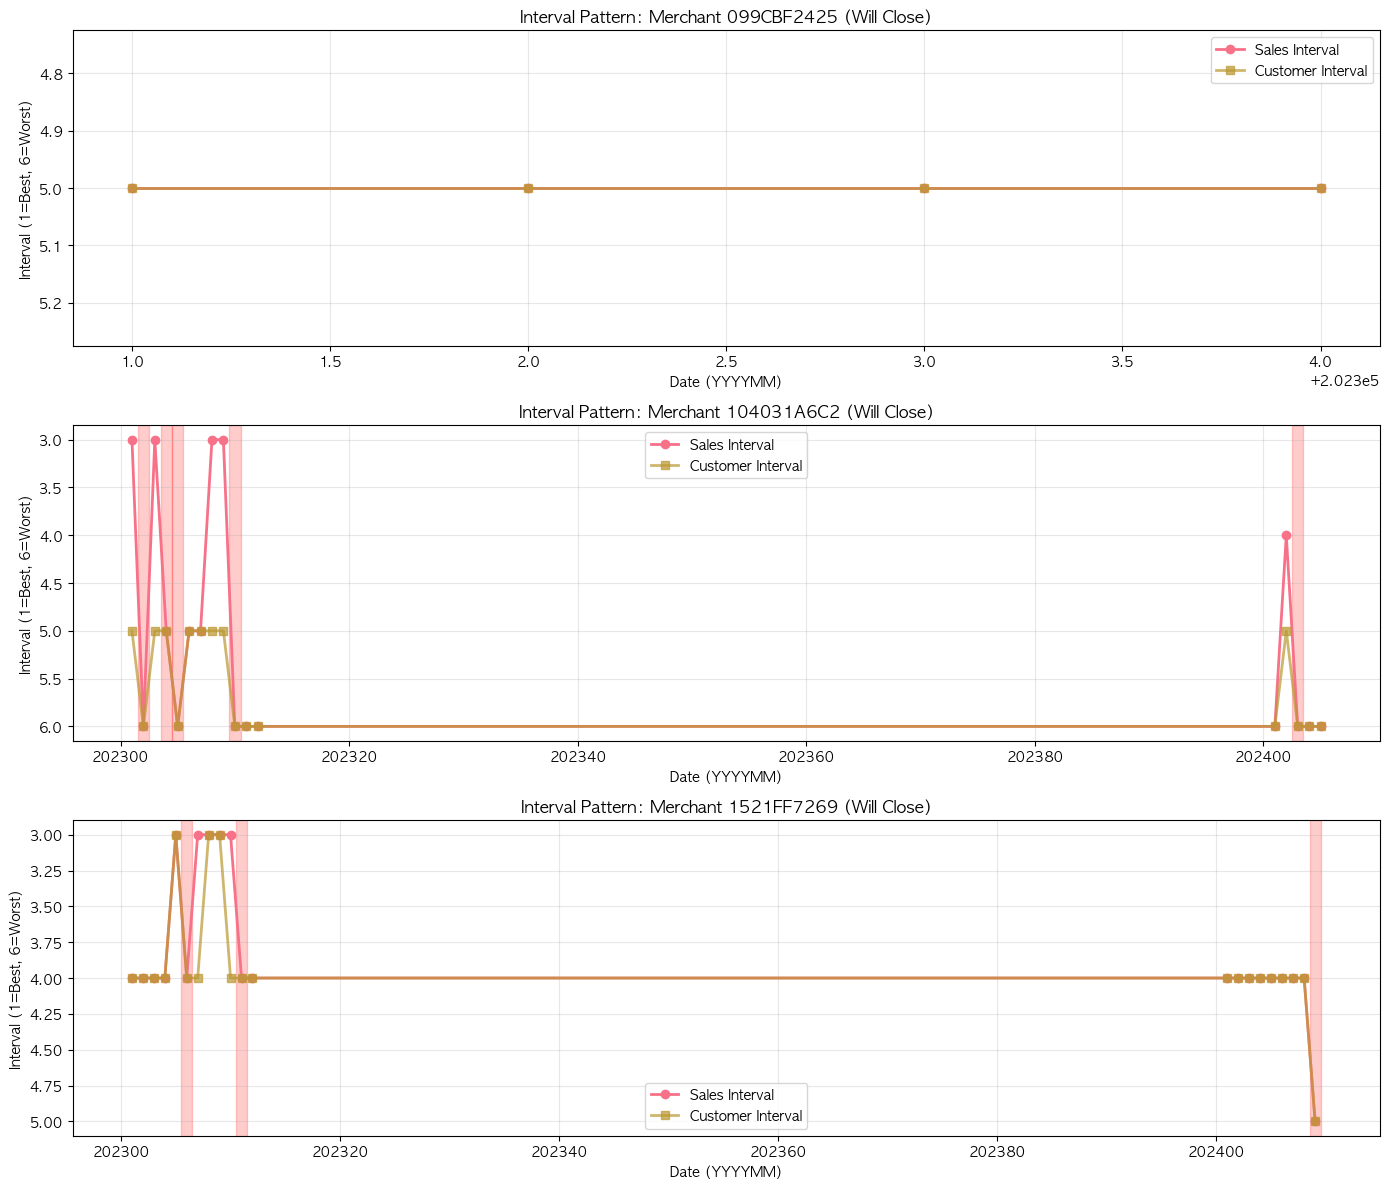

In [26]:
# 폐업 예정 가맹점의 구간 변화 패턴
if 'will_close_3m' in df_with_intervals.columns:
    # 폐업 예정 가맹점 샘플 추출
    closing_merchants = df_with_intervals[df_with_intervals['will_close_3m'] == 1]['ENCODED_MCT'].unique()
    
    if len(closing_merchants) > 0:
        sample_closing = closing_merchants[:3]  # 3개 샘플
        
        fig, axes = plt.subplots(len(sample_closing), 1, figsize=(14, 4*len(sample_closing)))
        if len(sample_closing) == 1:
            axes = [axes]
        
        for idx, merchant_id in enumerate(sample_closing):
            merchant_data = df_with_intervals[df_with_intervals['ENCODED_MCT'] == merchant_id].sort_values('TA_YM')
            
            ax = axes[idx]
            ax.plot(merchant_data['TA_YM'], merchant_data['RC_M1_SAA'], marker='o', linewidth=2, label='Sales Interval')
            
            if 'RC_M1_UE_CUS_CN' in merchant_data.columns:
                ax.plot(merchant_data['TA_YM'], merchant_data['RC_M1_UE_CUS_CN'], marker='s', linewidth=2, label='Customer Interval', alpha=0.7)
            
            ax.set_xlabel('Date (YYYYMM)', fontsize=10)
            ax.set_ylabel('Interval (1=Best, 6=Worst)', fontsize=10)
            ax.set_title(f'Interval Pattern: Merchant {merchant_id} (Will Close)', fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(alpha=0.3)
            ax.invert_yaxis()  # Lower interval = better
            
            # Mark decline periods
            if 'RC_M1_SAA_is_declining' in merchant_data.columns:
                decline_periods = merchant_data[merchant_data['RC_M1_SAA_is_declining'] == 1]
                for _, row in decline_periods.iterrows():
                    ax.axvspan(row['TA_YM'] - 0.5, row['TA_YM'] + 0.5, alpha=0.2, color='red')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No closing merchants found in dataset")

## 8. 데이터 저장

In [27]:
# 결측값 확인
missing_ratio = df_with_intervals[new_features].isnull().sum() / len(df_with_intervals) * 100
missing_ratio = missing_ratio[missing_ratio > 0].sort_values(ascending=False)

if len(missing_ratio) > 0:
    print(f"\nFeatures with missing values: {len(missing_ratio)}")
    print(f"\nTop 10 features with missing values:")
    print(missing_ratio.head(10))
else:
    print("\nNo missing values in new features!")


Features with missing values: 35

Top 10 features with missing values:
RC_M1_UE_CUS_CN_total_decline_12m    54.259152
RC_M1_TO_UE_CT_total_decline_12m     54.259152
RC_M1_SAA_total_decline_12m          54.259152
RC_M1_AV_NP_AT_total_decline_12m     54.259152
RC_M1_AV_NP_AT_decline_speed_6m      28.242291
RC_M1_AV_NP_AT_total_decline_6m      28.242291
RC_M1_UE_CUS_CN_total_decline_6m     28.242291
RC_M1_TO_UE_CT_decline_speed_6m      28.242291
RC_M1_UE_CUS_CN_decline_speed_6m     28.242291
RC_M1_TO_UE_CT_total_decline_6m      28.242291
dtype: float64


In [28]:
# Interval pattern features를 포함한 데이터 저장
output_path = Path('../data/processed')
output_path.mkdir(exist_ok=True)

csv_path = output_path / 'featured_data_with_intervals.csv'
df_with_intervals.to_csv(csv_path, index=False)

print(f"\nSaved to: {csv_path}")
print(f"File size: {csv_path.stat().st_size / 1024**2:.2f} MB")
print(f"Shape: {df_with_intervals.shape}")


Saved to: ../data/processed/featured_data_with_intervals.csv
File size: 57.02 MB
Shape: (86590, 148)


In [29]:
# Feature 목록 업데이트
import json

feature_list = {
    'total_features': len([col for col in df_with_intervals.columns if col not in ['ENCODED_MCT', 'TA_YM', 'will_close_1m', 'will_close_3m', 'months_until_close', 'is_valid_for_training']]),
    'interval_pattern_features': new_features,
    'decline_features': categories['Decline patterns'],
    'historical_worst_features': categories['Historical worst'],
    'recovery_features': categories['Recovery indicators'],
    'cross_metric_features': categories['Cross-metric']
}

feature_path = output_path / 'interval_feature_list.json'
with open(feature_path, 'w') as f:
    json.dump(feature_list, f, indent=2)

print(f"\nFeature list saved to: {feature_path}")
print(f"\nFeature statistics:")
print(f"  Total features: {feature_list['total_features']}")
print(f"  Interval pattern features: {len(feature_list['interval_pattern_features'])}")
print(f"    - Decline features: {len(feature_list['decline_features'])}")
print(f"    - Historical worst features: {len(feature_list['historical_worst_features'])}")
print(f"    - Recovery features: {len(feature_list['recovery_features'])}")
print(f"    - Cross-metric features: {len(feature_list['cross_metric_features'])}")


Feature list saved to: ../data/processed/interval_feature_list.json

Feature statistics:
  Total features: 142
  Interval pattern features: 101
    - Decline features: 47
    - Historical worst features: 20
    - Recovery features: 28
    - Cross-metric features: 9


## 9. 결론

### 완료된 작업
1. ✅ Interval decline pattern features (연속 하락, 하락 속도, 하락 빈도)
2. ✅ Historical worst indicators (최저 구간, 최고 구간 대비 격차)
3. ✅ Recovery indicators (회복 패턴, 변동성)
4. ✅ Cross-metric divergence features (매출 vs 고객 구간 비교)

### 핵심 인사이트
- **연속 하락 개월 수**가 폐업 위험의 가장 강력한 신호
- **역대 최저 구간 도달** 시 위험도 급증
- **매출 구간 하락 + 고객 구간 안정** = 가격/품질 문제 시사
- **매출/고객 모두 하락** = 치명적 위험 신호

### 다음 단계
- 기존 featured_data.csv와 병합
- 모델 학습 시 interval pattern features의 중요도 확인
- SHAP 분석으로 위기 신호 해석

In [30]:
print("\n" + "="*80)
print("INTERVAL PATTERN FEATURE ENGINEERING COMPLETED")
print("="*80)
print(f"\nFinal dataset: {df_with_intervals.shape}")
print(f"New features added: {len(new_features)}")
print(f"Saved to: {csv_path}")
print("\nReady for Model Training!")


INTERVAL PATTERN FEATURE ENGINEERING COMPLETED

Final dataset: (86590, 148)
New features added: 101
Saved to: ../data/processed/featured_data_with_intervals.csv

Ready for Model Training!
